In [8]:
import pandas as pd
import os

import matplotlib.pyplot as plt

import cv2


In [2]:
img_path = 'image_classification/'
img_labels = ['abomination','aero']

In [3]:
img_list = []
label_list = []
for label in img_labels:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)
        
df = pd.DataFrame({'img':img_list, 'label':label_list})

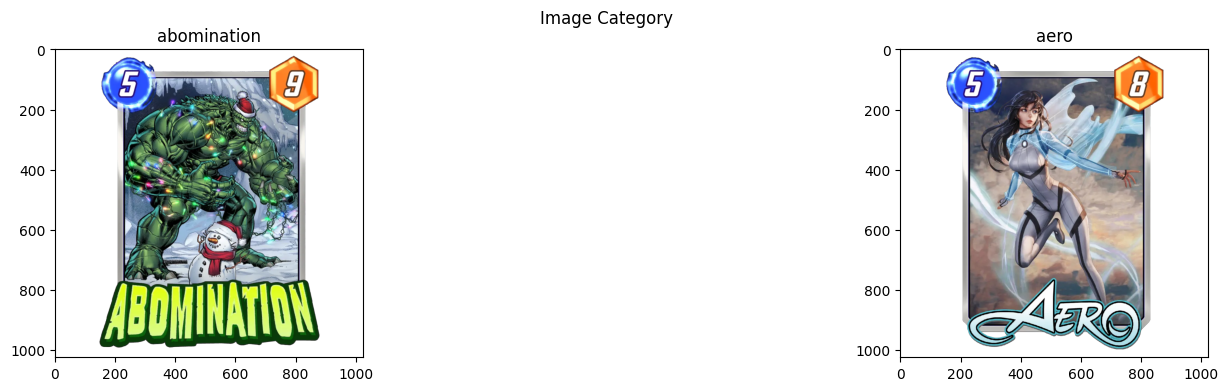

In [5]:
fig, ax = plt.subplots(ncols=len(img_labels), figsize=(20,4))
fig.suptitle('Image Category')
random_num = 2
for i,label in enumerate(img_labels):
    ax[i].set_title(label)
    ax[i].imshow(plt.imread(df[df['label']==label]['img'].iloc[random_num]))

In [6]:
plt.imread(df['img'][0]).shape

(1024, 1024, 4)

In [7]:
df_labels = {
    'abomination' : 0,
    'aero' : 1
}

df['encode_label'] = df['label'].map(df_labels)
df.head()

,img,label,encode_label
0,image_classification/abomination/1_16619650426...,abomination,0
1,image_classification/abomination/1_16619650425...,abomination,0
2,image_classification/abomination/1_16619650425...,abomination,0
3,image_classification/abomination/abomination.webp,abomination,0
4,image_classification/abomination/1_16619650438...,abomination,0


In [9]:
X = []

for img in df['img']:
    img = cv2.imread(str(img))
    # img = augment_function(img)
    img = cv2.resize(img, (500, 500))
    img = img/255
    X.append(img)

In [11]:
df['encode_label']

0     0
1     0
2     0
3     0
4     0
5     1
6     1
7     1
8     1
9     1
10    1
11    1
Name: encode_label, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [15]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape=(500,500,3), include_top=False, weights='imagenet')

base_model.summary()

2022-12-29 23:31:27.047212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 23:31:36.093320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 23:31:36.094403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 23:31:36.094802: I tensorflow/core/

Metal device set to: AMD Radeon Pro 5500M
58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                    

In [16]:
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [19]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
model = Sequential()
model.add(Input(shape=(96,96,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(img_labels), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 15, 512)       14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_4 (Dropout)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 15,895,106
Trainable params: 8,259,842
N

In [20]:
model.compile(
  optimizer="adam",
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

ValueError: Data cardinality is ambiguous:
  x sizes: 500, 500, 500, 500, 500, 500, 500, 500, 500
  y sizes: 9
Make sure all arrays contain the same number of samples.